# 27.09.2024

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import random
import math
import time
from tqdm import tqdm

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

In [3]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
norm_quantile = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
ANALYTICAL_EXPECTATION = 0
ANALYTICAL_MEDIAN = 0
ITERATIONS = 10 ** 4
BOOTSTRAP_SIZE = 1000
DISTROS = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
# NS = [10, 100, 500]
min_sample_size = 50
max_sample_size = 500
num_of_sample_sizes = 5
BASE = 5
# NS = list(map(int, np.linspace(min_sample_size, max_sample_size, num_of_sample_sizes)))
NS = list(map(int, np.logspace(base=BASE, start=math.log(min_sample_size, BASE), stop=math.log(max_sample_size, BASE), num=num_of_sample_sizes)))
print(NS)

[50, 88, 158, 281, 500]


In [4]:
ANALYTICAL_MADS = {d: 0.0 for d in DISTROS}

Для того чтобы оценить, сколько доверительных интервалов на самом деле содержат реальные MAD, нужно их сначала найти для наших распределений.
Мы знаем, что
$$\text{MAD}(X) = \text{median}(|X-\text{median}(X)|)$$
Поскольку для каждого из наших распределений медиана равна нулю, то
$$\text{MAD}(X) = \text{median}(|X|)$$
Найти это легко для $\text{Uniform}[-1, 1]$, поскольку его модуль превращается просто в $\text{Uniform}[0, 1]$, а значит его $\text{MAD} = 0.5$.

In [5]:
ANALYTICAL_MADS["Uniform[-1, 1]"] = 0.5

Уже несколько сложнее для $\text{Norm}(0, 1)$. Найдём функцию распределения модуля стандартного распределения. 
$$F_{|Norm(0, 1)|}(t) = \int_{-\infty}^t p_{|Norm(0, 1)|}(x)dx = \int_{-\infty}^t (p_{Norm(0, 1)}(x) + p_{Norm(0, 1)}(-x)) \cdot \mathbb{1}_{[0, +\infty)}(x) dx = 2 \cdot \int_{0}^t p_{Norm(0, 1)}(x) dx =$$
$$[t \geqslant 0] = 2 \cdot \left(\int_{-\infty}^t p_{Norm(0, 1)}(x) dx - \int_{-\infty}^0 p_{Norm(0,1)} dx\right) = 2\cdot (\Phi(t) - 0.5) = 2\Phi(t) - 1$$
в силу симметричности стандартного нормального распределения.

По определению, медиана $m: \; \mathbb{P}(\xi \leqslant m) = \frac{1}{2}$, то есть $F(m) = \frac{1}{2}$. Для модуля стандартного нормального распределения это $$2\Phi(m) - 1 = \frac{1}{2} \Rightarrow \Phi(m) = 0.75 \Rightarrow m \text{ - }75\%\text{-ая квантиль Norm}(0, 1).$$

In [6]:
ANALYTICAL_MADS["Norm(0, 1)"] = sps.norm.ppf(0.75, loc=0, scale=1)

Для $2\cdot \text{Uniform[-1, 1]}$ нужно найти функцию распределения и по ней бинпоиском медиану. Для этого проинтегрируем свёртку плотностей равномерных распределений, то есть
$$\xi, \eta \sim \text{Uniform[-1, 1]}$$
$$F_{\xi + \eta}(t) = \int_{-\infty}^t p_{\xi + \eta}(x) dx = \int_{-\infty}^t \int_{\mathbb{R}} p_\xi(y)\cdot p_\eta(x-y)dy dx$$
Внутренний интеграл легко посчитать и аналитически записать полученную функцию. 

Чтобы получить плотность распределения $|2 \cdot \text{Uniform}[-1, 1]|$ в точке $t$, сложим плотности в точках $-t$ и $t$, при условии $0 \leqslant t$. Итого можем посчитать функцию распределения модуля суммы двух равномерных распределений:

In [7]:
def uniform_sum_pdf(t: float) -> float:
    if t <= -2 or t >= 2:
        return 0
    if -2 < t <= 0:
        return (2 + t) / 4
    return (2 - t) / 4

def abs_uniform_sum_pdf(t):
    return uniform_sum_pdf(t) + uniform_sum_pdf(-t) if t >= 0 else 0

def uniform_sum_cdf(t):
    return integrate.quad(uniform_sum_pdf, -np.inf, t)[0]

def abs_uniform_sum_cdf(t):
    return integrate.quad(abs_uniform_sum_pdf, -np.inf, t)[0]

In [8]:
def binary_search_median(cdf, lower_bound, upper_bound, tol=1e-6):
    while upper_bound - lower_bound > tol:
        mid = (lower_bound + upper_bound) / 2
        if cdf(mid) < 0.5:
            lower_bound = mid
        else:
            upper_bound = mid
    return (lower_bound + upper_bound) / 2

In [9]:
ANALYTICAL_MADS["2xUniform[-1, 1]"] = binary_search_median(abs_uniform_sum_cdf, 0, 2, tol=1e-10)

Визуализация для наглядности

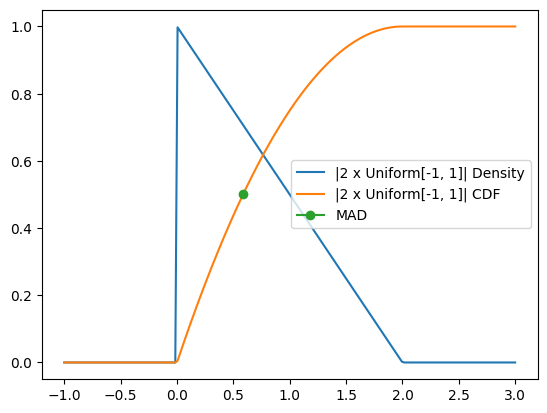

In [10]:
x = np.linspace(-1, 3, 200)
y1 = [abs_uniform_sum_pdf(t) for t in x]
y2 = [abs_uniform_sum_cdf(t) for t in x]
    
plt.plot(x, y1, label='|2 x Uniform[-1, 1]| Density')
plt.plot(x, y2, label='|2 x Uniform[-1, 1]| CDF')
plt.plot(ANALYTICAL_MADS["2xUniform[-1, 1]"], abs_uniform_sum_cdf(ANALYTICAL_MADS["2xUniform[-1, 1]"]), '-o', label='MAD')
plt.legend()
plt.show()

In [11]:
print(ANALYTICAL_MADS)

{'Uniform[-1, 1]': 0.5, 'Norm(0, 1)': np.float64(0.6744897501960817), '2xUniform[-1, 1]': 0.5857864380523097}


Функции подсчёта доверительного интервала для MAD (Median Absolute Deviation)

In [12]:
def bootstrap_confidence_interval(sample, statistic, confidence_probability = 0.95) -> tuple:
    bootstrap_estimates = [statistic(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(BOOTSTRAP_SIZE)]
    return (np.percentile(bootstrap_estimates, ((1 - confidence_probability) / 2) * 100),
            np.percentile(bootstrap_estimates, 100 - ((1 - confidence_probability) / 2) * 100))

In [13]:
from functools import lru_cache
@lru_cache
def z_score(confidence_probability: float) -> float:
    return np.sqrt(2) * special.erfinv(confidence_probability)

def jackknife_confidence_interval(sample, statistic, confidence_probability = 0.95) -> tuple[float, float]:
    n = len(sample)
    jackknife_estimates = [statistic(np.delete(sample, i)) for i in range(n)]
    jackknife_mean = np.mean(jackknife_estimates)
    jackknife_std_err = np.sqrt((n - 1) * np.mean((jackknife_estimates - jackknife_mean) ** 2))
    term = z_score(confidence_probability) * jackknife_std_err
    return (jackknife_mean - term, jackknife_mean + term)

Сгенерируем по $10^4$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал для MAD, посчитав доверительный интервал для этой доли.

In [14]:
methods = ["bootstrap", "jackknife"]
NUM_METHODS = len(methods)
methods_functions = {"bootstrap": bootstrap_confidence_interval, "jackknife": jackknife_confidence_interval}

In [15]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(DISTROS)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [00:18<00:00,  6.03s/it]

Samples generated.


Теперь приступим к подсчёту доверительных интервалов для MAD

In [16]:
results = {d: {m + g: [] for m in methods for g in ['_intervals', '_points']} for d in DISTROS}
for i, d in enumerate(DISTROS):
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method in methods:
            print(f"    {method.capitalize()}:")
            hits_counter = 0
            for sample in tqdm(samples[d][n_id]):
                d_left, d_right = methods_functions[method](sample=sample, statistic=sps.median_abs_deviation)
                hits_counter += d_left <= ANALYTICAL_MADS[d] <= d_right
                
            results[d][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
            results[d][method + "_points"].append(hits_counter / ITERATIONS)
    print('-' * 40)

Distribution Uniform[-1, 1], samples size = 50
    Bootstrap:


100%|██████████| 10000/10000 [12:49<00:00, 12.99it/s]


    Jackknife:


100%|██████████| 10000/10000 [00:34<00:00, 289.73it/s]


Distribution Uniform[-1, 1], samples size = 88
    Bootstrap:


100%|██████████| 10000/10000 [13:04<00:00, 12.76it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:02<00:00, 160.88it/s]


Distribution Uniform[-1, 1], samples size = 158
    Bootstrap:


100%|██████████| 10000/10000 [13:48<00:00, 12.06it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:54<00:00, 86.97it/s]


Distribution Uniform[-1, 1], samples size = 281
    Bootstrap:


100%|██████████| 10000/10000 [15:20<00:00, 10.86it/s]


    Jackknife:


100%|██████████| 10000/10000 [03:38<00:00, 45.83it/s]


Distribution Uniform[-1, 1], samples size = 500
    Bootstrap:


100%|██████████| 10000/10000 [16:38<00:00, 10.02it/s]


    Jackknife:


100%|██████████| 10000/10000 [06:55<00:00, 24.10it/s]


----------------------------------------
Distribution Norm(0, 1), samples size = 50
    Bootstrap:


100%|██████████| 10000/10000 [12:55<00:00, 12.89it/s]


    Jackknife:


100%|██████████| 10000/10000 [00:35<00:00, 285.56it/s]


Distribution Norm(0, 1), samples size = 88
    Bootstrap:


100%|██████████| 10000/10000 [13:12<00:00, 12.62it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:02<00:00, 159.29it/s]


Distribution Norm(0, 1), samples size = 158
    Bootstrap:


100%|██████████| 10000/10000 [13:58<00:00, 11.93it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:56<00:00, 86.02it/s]


Distribution Norm(0, 1), samples size = 281
    Bootstrap:


100%|██████████| 10000/10000 [15:18<00:00, 10.88it/s]


    Jackknife:


100%|██████████| 10000/10000 [03:37<00:00, 45.91it/s]


Distribution Norm(0, 1), samples size = 500
    Bootstrap:


100%|██████████| 10000/10000 [16:29<00:00, 10.11it/s]


    Jackknife:


100%|██████████| 10000/10000 [06:53<00:00, 24.19it/s]


----------------------------------------
Distribution 2xUniform[-1, 1], samples size = 50
    Bootstrap:


100%|██████████| 10000/10000 [12:55<00:00, 12.89it/s]


    Jackknife:


100%|██████████| 10000/10000 [00:35<00:00, 285.30it/s]


Distribution 2xUniform[-1, 1], samples size = 88
    Bootstrap:


100%|██████████| 10000/10000 [13:09<00:00, 12.67it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:02<00:00, 159.99it/s]


Distribution 2xUniform[-1, 1], samples size = 158
    Bootstrap:


100%|██████████| 10000/10000 [13:55<00:00, 11.97it/s]


    Jackknife:


100%|██████████| 10000/10000 [01:55<00:00, 86.29it/s]


Distribution 2xUniform[-1, 1], samples size = 281
    Bootstrap:


100%|██████████| 10000/10000 [15:14<00:00, 10.93it/s]


    Jackknife:


100%|██████████| 10000/10000 [03:37<00:00, 45.94it/s]


Distribution 2xUniform[-1, 1], samples size = 500
    Bootstrap:


100%|██████████| 10000/10000 [16:29<00:00, 10.10it/s]


    Jackknife:


100%|██████████| 10000/10000 [06:51<00:00, 24.28it/s]

----------------------------------------


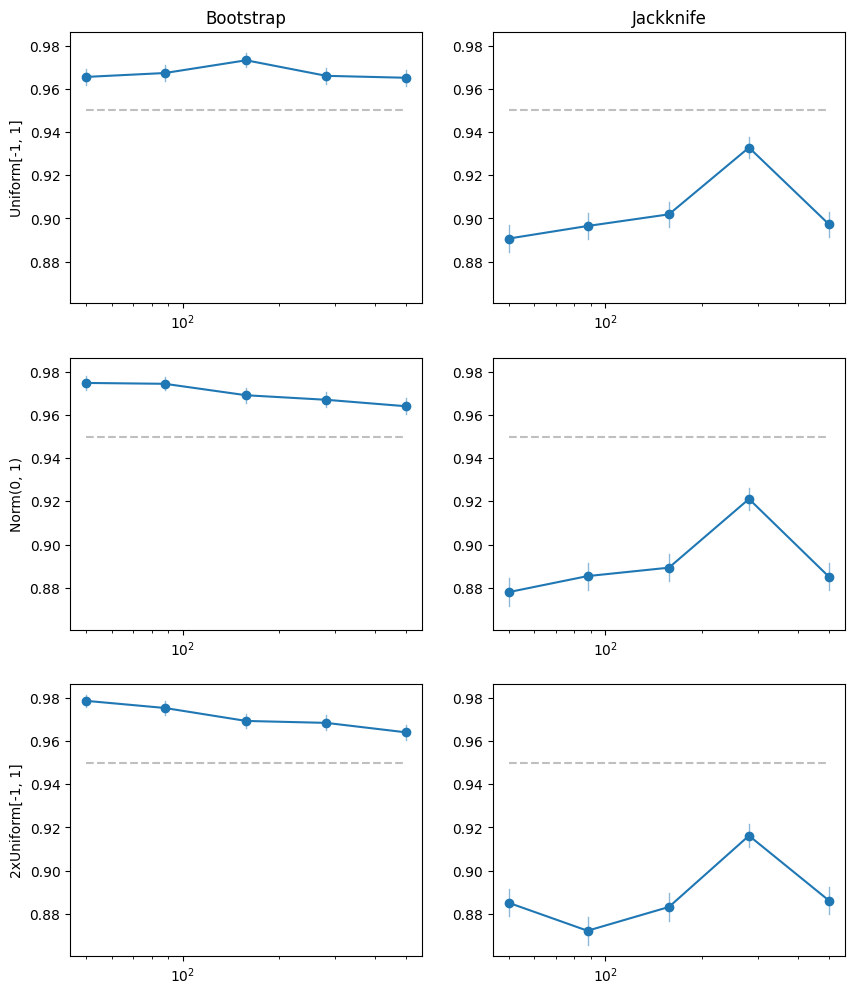

In [18]:
_, axis = plt.subplots(len(DISTROS), NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(DISTROS)))
max_y, min_y = 0.0, 10.0
for i, d in enumerate(DISTROS):
    for method_id, method in enumerate(methods):
        for interval_id, interval in enumerate(results[d][method + "_intervals"]):
            axis[i][method_id].plot([NS[interval_id]] * 2, list(interval), alpha=.5, linewidth=1, color='C0')
            max_y, min_y = max(max_y, interval[1]), min(min_y, interval[0])
        axis[i][method_id].plot(NS, results[d][method + "_points"], '-o', alpha=1, color='C0')         
        axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')         
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([0.85, 1.05])
        axis[0][method_id].title.set_text(method.capitalize())
    axis[i][0].set_ylabel(d)
for i in range(len(DISTROS)):
    for j in range(len(methods)):
        axis[i][j].set_ylim([min_y - 0.005, max_y + 0.005])
plt.show()